# Finetune ResNet


In [1]:
from utils_webots import *
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"
num_classes = 1
batch_size = 16
num_epochs = 10

from cnn import ConvNeuralNet
model_ft = ConvNeuralNet(1)  # one class

# model_ft = models.squeezenet1_0(weights= True)
# model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
# model_ft.num_classes = num_classes

# model_ft = models.resnet18(weights=True)
## set_parameter_requires_grad(model_ft, feature_extract)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, num_classes)
# input_size = 224

print("Initializing Datasets and Dataloaders...")
data_transforms = transforms.Compose([transforms.ToTensor()]) #, transforms.Resize((input_size, input_size)), ])
dataset = WeBotsDataset(filename='df_follower_new', transform=data_transforms) # WeBotsDataset(transform=data_transforms)

# # Create training and validation datasets
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

dataloaders_dict = {'train': train_loader, 'val': test_loader}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Send the model to GPU
model_ft = model_ft.to(device)

# Sanity check
img, target = next(iter(dataset))
# plt.imshow(img[0]), target
model_ft(img.cuda().float().unsqueeze(0))


# Observe that all parameters are being optimized
params_to_update = model_ft.parameters()
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.MSELoss()

# Train and evaluate

PyTorch Version:  1.13.1
Torchvision Version:  0.14.1
Initializing Datasets and Dataloaders...


(array([7.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
        3.000e+00, 6.000e+00, 4.000e+00, 4.000e+00, 3.000e+00, 1.100e+01,
        1.000e+01, 2.500e+01, 8.700e+01, 3.010e+02, 6.880e+02, 5.790e+02,
        9.860e+02, 1.526e+03, 1.722e+03, 1.669e+03, 2.635e+03, 1.645e+03,
        1.052e+03, 6.100e+02, 4.100e+02, 5.720e+02, 4.450e+02, 4.490e+02,
        2.340e+02, 1.950e+02, 1.300e+02, 1.480e+02, 5.900e+01, 3.760e+02,
        5.680e+02, 5.540e+02, 4.140e+02, 6.000e+01, 1.400e+01, 1.100e+01,
        8.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 5.000e+00]),
 array([-0.5     , -0.482968, -0.465936, -0.448904, -0.431872, -0.41484 ,
        -0.397808, -0.380776, -0.363744, -0.346712, -0.32968 , -0.312648,
        -0.295616, -0.278584, -0.261552, -0.24452 , -0.227488, -0.210456,
        -0.193424, -0.176392, -0.15936 , -0.142328, -0.125296, -0.108264,
        -0.091232, -0.0742  , -0.057168, -0.040136, -0.023104, -0.006072,
      

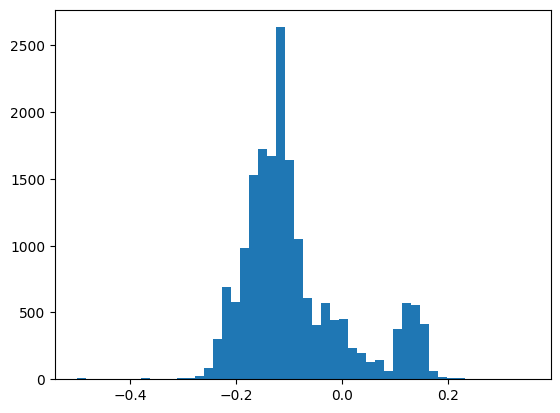

In [17]:
plt.hist(dataset.df_loaded['angle'],bins=50)

# model_ft
# i, t = next(iter(train_loader))
# model_ft(img[0].unsqueeze(0))

In [11]:

# img = next(iter(train_loader))
# plt.imshow(img[0][0][0])
# img[0].shape
# model_ft(img[0].cuda())

tensor([-0.0198, -0.0025,  0.0008,  0.0016, -0.0301, -0.0140, -0.0092,  0.0056,
        -0.0213, -0.0022,  0.0083,  0.0045, -0.0130, -0.0045, -0.0044, -0.0045],
       device='cuda:0', grad_fn=<SqueezeBackward0>)

In [11]:
model, dataloaders, optimizer, num_epochs, is_inception = model_ft, dataloaders_dict, optimizer_ft, num_epochs, (model_name=="inception")

since = time.time()

val_acc_history = []

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, (_, labels) in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                # Get model outputs and calculate loss
                # Special case for inception because in training it has an auxiliary output. In train
                #   mode we calculate the loss by summing the final output and the auxiliary output
                #   but in testing we only consider the final output.
                outputs = model(inputs)
                # print(outputs.shape, labels.shape)
                # loss = criterion(outputs, labels.unsqueeze(1).float())
                # print(outputs.shape, labels.shape)
                loss = criterion(outputs, labels.float())

                # print(loss)
                # _, preds = torch.max(outputs, 1)
                preds = outputs

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum( (preds - labels.data) < 1e-2) # just a threshold

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        if phase == 'val':
            val_acc_history.append(epoch_acc)

    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

# load best model weights
model.load_state_dict(best_model_wts)
torch.save(model.cpu().state_dict(), 'model_weights_small_angle.pth')

Epoch 0/9
----------
train Loss: 0.0024 Acc: 0.5513
val Loss: 0.0021 Acc: 0.6668

Epoch 1/9
----------


/home/matteogu/miniconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train Loss: 0.0021 Acc: 0.5531
val Loss: 0.0019 Acc: 0.6854

Epoch 2/9
----------
train Loss: 0.0019 Acc: 0.5594
val Loss: 0.0018 Acc: 0.6873

Epoch 3/9
----------
train Loss: 0.0018 Acc: 0.5607
val Loss: 0.0018 Acc: 0.6881

Epoch 4/9
----------
train Loss: 0.0017 Acc: 0.5632
val Loss: 0.0017 Acc: 0.6884

Epoch 5/9
----------
train Loss: 0.0017 Acc: 0.5657
val Loss: 0.0017 Acc: 0.6816

Epoch 6/9
----------
train Loss: 0.0016 Acc: 0.5674
val Loss: 0.0016 Acc: 0.6783

Epoch 7/9
----------
train Loss: 0.0016 Acc: 0.5698
val Loss: 0.0016 Acc: 0.6742

Epoch 8/9
----------
train Loss: 0.0016 Acc: 0.5705
val Loss: 0.0016 Acc: 0.6679

Epoch 9/9
----------
train Loss: 0.0015 Acc: 0.5726
val Loss: 0.0016 Acc: 0.6643

Training complete in 0m 38s
Best val Acc: 0.688408


In [12]:
preds, labels.data


(tensor(-0.1711, device='cuda:0'), tensor([-0.1953], device='cuda:0'))

In [16]:
torch.save(model.cpu().state_dict(), 'model_weights.pth')

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.